# Getting Started SNN!

## From Neuron to Network

In [1]:
import numpy as np

from matplotlib import pyplot as plt
from snn.spiking_neuron import create_SCTN


### The SCTN

Initiating simple SCTN neuron

In [40]:
neuron = create_SCTN()

Spiking neurons are getting spikes as input, the neruons are connected with synapses and each synapse has weight. To define how many synapse and what its corresponded weight you need to set it using synapses_weights

Lets set the neuron with 1 synapse with weight of 10.

In [41]:
neuron.synapses_weights = np.array([10])

The SCTN has 3 different activation functions, lets use the `BINARY` activation function which is simlar how the LIF neuron model works and set the threshold to emit spike to 100.

In [42]:
from snn.spiking_neuron import BINARY

neuron.activation_function = BINARY
neuron.threshold_pulse = 100

The SCTN has several parameters, include leakage-factor and leakage-period that control the leakage of the membrane.
The neuron has inner timer that increase every tick, when the timer count to `leakage_period` the timer set back to 0 and the membrane reduce by (`membrane_potential / 2 ** leakage_factor`)
Lets set `leakage_factor` to 1 and `leakage_period` to 1.

In [43]:
neuron.leakage_factor = 1
neuron.leakage_period = 1

SCTN is type of LIF Model!
Let's see how it works.
First set the neuron to save its values through time. the membrane potential and its emitted spikes.

In [44]:
neuron.log_out_spikes = True
neuron.log_membrane_potential = True

Now lets watch what happened after a spike

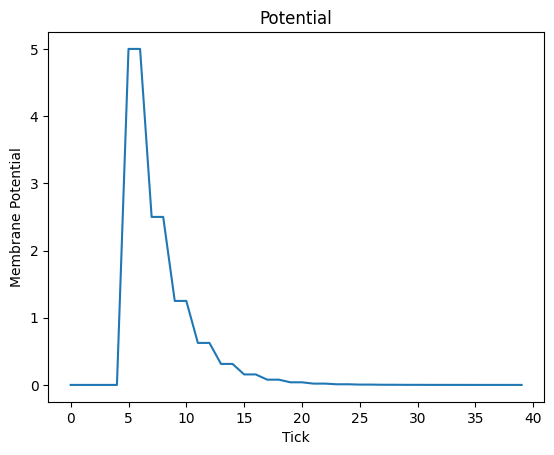

In [48]:
def simulate():
    spikes_input = np.zeros(40)
    spikes_input[5] = 1

    for s in spikes_input:
        # neuron may have several inputs from different source so the input should be wrapped in another array
        neuron.ctn_cycle(np.array([s]), True)


    membrane_potential = neuron.membrane_potential_graph()
    plt.plot(membrane_potential)
    plt.ylabel('Membrane Potential')
    plt.xlabel('Tick')
    plt.title("Potential")

neuron.forget_logs()
simulate()

You see how th potential decrease every tick. You can delay the decrease using the `leakage_period`

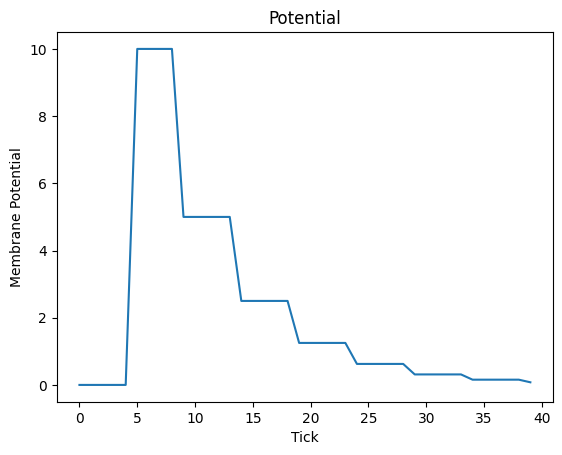

In [50]:
neuron.leakage_period = 4

neuron.forget_logs()
simulate()

You also can make the decrease less aggressive with `leakage_factor`.
*Be aware that leakage_factor affect the weight of the input*

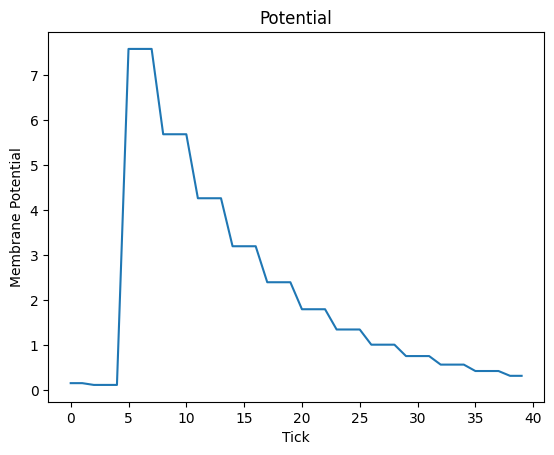

In [54]:
neuron.leakage_factor = 2
neuron.leakage_period = 2

neuron.forget_logs()
simulate()